In [6]:
# Ajustar ruta a la raiz del proyecto
import re
import os
if not 'id_0123456789876543210' in locals():
    _rootlevel = 3
    _oldwd = re.sub(r'\\', '/', os.getcwd())
    _spdirs = _oldwd.split('/')
    _newwd = '/'.join(_spdirs[:(len(_spdirs)-_rootlevel)])
    os.chdir(_newwd)
    id_0123456789876543210 = None
print(f'Old WD: {_oldwd}')
print(f'New WD: {_newwd}')

Old WD: d:/Itzco/Documents/GitHub/BTC-LSTM/src/python/jnotes
New WD: d:/Itzco/Documents/GitHub/BTC-LSTM


In [7]:

from src.python.util.basic import load_arrow
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#4C72B0'])

# I Descripción de datos

A continuación, se describen las variables de las bases de datos del precio del bitcoin, descargados desde la plataforma Binance:

- **Time**: La marca de tiempo (minutos) que indica el inicio del intervalo en el que se registra la información.

- **Open**: El precio de apertura del Bitcoin en un período de tiempo específico.

- **High**: El precio más alto alcanzado por el Bitcoin en ese mismo período.

- **Low**: El precio más bajo registrado para el Bitcoin durante el mismo período.

- **Close**: El precio de cierre del Bitcoin en el mismo período de tiempo.

- **Volume**: La cantidad total de Bitcoin negociada en el mercado durante el período.

- **VolumeUSDT**: La cantidad total en dólares estadounidenses (USDT) negociada durante el período.

- **TakerVolume**: La cantidad de Bitcoin intercambiada por los tomadores de mercado durante el período de tiempo especificado.

- **TakerVolumeUSDT**: La cantidad en dólares estadounidenses (USDT) intercambiada por los tomadores de mercado durante el mismo período de tiempo.

- **Trades**: El número total de transacciones o operaciones realizadas durante el período especificado.


**Nota**: Los tomadores de mercado son aquellos que toman las ofertas existentes por lo que aportan liquidez al mercado.

In [8]:
# carga de datos descargados en termporalidad de "30m"
data = load_arrow('data/01 download', 'BTCUSDT_30m')
data

,Time,Open,High,Low,Close,Volume,VolumeUSDT,TakerVolume,TakerVolumeUSDT,Trades
0,25049040.0,4261.48,4280.56,4261.32,4261.45,11.308926,4.822475e+04,3.936174,1.679304e+04,49
1,25049070.0,4280.00,4313.62,4267.99,4308.83,35.872083,1.541414e+05,31.224329,1.341594e+05,122
2,25049100.0,4308.83,4328.69,4304.31,4320.00,21.048648,9.086429e+04,19.396570,8.374608e+04,73
3,25049130.0,4320.00,4320.00,4291.37,4315.32,2.186268,9.440531e+03,2.051501,8.862196e+03,29
4,25049160.0,4330.29,4330.29,4309.37,4311.02,3.566277,1.540976e+04,2.302077,9.951673e+03,14
...,...,...,...,...,...,...,...,...,...,...
109003,28327380.0,37246.45,37424.22,37231.10,37339.41,996.221920,3.718456e+07,435.909930,1.626992e+07,25290
109004,28327410.0,37339.41,37339.41,37210.00,37225.96,777.111750,2.896647e+07,335.590510,1.250921e+07,22239
109005,28327440.0,37225.96,37239.43,37070.19,37133.22,873.402850,3.245105e+07,380.596030,1.413976e+07,24775
109006,28327470.0,37133.22,37274.82,37130.18,37231.86,480.041580,1.786424e+07,241.924020,9.001242e+06,17560


# II Limpieza de datos

Los datos del precio de mercado se generan en tiempo continuo por lo que no deberían existir "huecos" en los mismos. Sin embargo, por razones desconocidas, se identificaron algunos datos que no se encuentran registrados en los servidores de Binance. Esto podemos constatarlo con la variable **Time** ya que si existen saltos irregulares entre sus valores significaría que hay datos no registrados. Para este caso, en particular, los saltos de tiempo deben ser de 30 minutos:

In [9]:
index = np.where(data['Time'].diff() != 30)[0][1:]
print(f'Indices con saltos de tiempo:\n{index}')

empty = (np.array(data['Time'][index])-np.array(data['Time'][index-1]))/30
print(f'\nNúmero de datos faltantes en cada salto:\n{empty}')

print(f'\nTotal de datos faltantes:  {sum(empty)}')

print(
    f'\nLos datos faltantes representan un {round(100*sum(empty)/len(data),2)}% del los datos si registrados.')

Indices con saltos de tiempo:
[  985  5908  6704  8375 14935 14985 15293 20425 21658 27308 30370 31491
 34763 39067 39639 43283 43781 44437 46914 49981 57422 58444 58604 60910
 62008 64165 64405 69672 71929 97905]

Número de datos faltantes en cada salto:
[14.  3.  4. 68. 21.  4. 16.  8. 15. 13. 21.  2. 17.  5.  5.  3. 12.  5.
  6.  8.  3.  9.  3.  3.  4.  6.  9. 10.  5.  3.]

Total de datos faltantes:  305.0

Los datos faltantes representan un 0.28% del los datos si registrados.


Dicho lo anterior, los "huecos", que registran los datos, representan una proporción minúscula en comparación al tamaño total porque que resulta razonable estimar dicha información con base en los datos existentes. De manera general, para el caso de los precios, la estimación se realiza por medio de aproximaciones lineales entre los extremos de los datos existentes, en los casos de **High** y **Low** se añade, además de lo anterior, un factor de volatilidad proporcional a la cantidad de datos faltantes. Para estimar los volúmenes de operación se utiliza el promedio de los datos previos registrados con una ventana igual al tamaño de datos faltantes.

En el archivo `data/info/BLOCK_BTCUSDT_30m.csv` se encuentra una descripción de los bloques de datos que no registran información faltante, y la cantidad de datos que fueron estimados al final de cada bloque. Las bases de datos "limpias" fueron guardas en `data/02 clean` y les fue añadida la variable binaria **Filled** que indica si el renglón en cuestión fue estimado ($1$) o es original ($0$).

<figure>
    <img src="img/empty.jpg"  width="75%" />
    <figcaption>Las regiones sombreadas marcan los datos que fueron completados.</figcaption>
</figure>



Por otro lado, en cuando a la calidad de datos existentes, se observa un comportamiento atípico en los primeros registros, causado por la baja cantidad de operaciones en el mercado, esto se debe a que la plataforma Binance comenzó a operar a mediados del año 2017 y nuestro primer registro de datos se ubica en la fecha 2017-08-16. Con el propósito de eliminar el sesgo causado por la falta de operaciones en el mercado, se opta por restringir una fecha mínima para el análisis, la fecha elegida es el 2018-02-12 la cual puede ser modificada, antes de realizar la transformación de los datos, en el archivo `src/python/util/parameters.json`.

<figure>
    <img src="img/logtrades.jpg"  width="60%" />
    <figcaption>Al inicio del periodo, se observa un reducido nivel de operaciones.</figcaption>
</figure>

# III Transformación de datos

Después de realizar la limpieza de los datos, el script `test/02 transform.py` lee la información de la carpeta `data/02 clean`, realiza una serie de transformaciones y guarda los resultados en la carpeta `data/03 transform`. Las transformaciones aplicadas se dividen en tres grupos:

- **Logarítmicas:**  
Dada $X$ una serie de tiempo, definimos la transformación logarítmica como $\log\left(c+X\right)$, para alguna constante $c$. Esta transformación tiene el propósito de reducir el sesgo de las series y por lo tanto disminuir la cantidad de valores extremos. Las series obtenidas por este método fueron las siguientes:

    - **Open_Log** $=\log\left(\right.$**Open** $\left.\right)$
    - **High_Log** $=\log\left(\right.$**High**$\left.\right)$
    - **Low_Log** $=\log\left(\right.$**Low**$\left.\right)$
    - **Close_Log** $=\log\left(\right.$**Close**$\left.\right)$
    - **Volume_Log** $=\log\left(\right. 1\,+\,$**Volume**$\left.\right)$

- **Normalizadas (normalización móvil):**  
Dados $X$ una serie de tiempo, $m_X$ la estimación de su media a lo largo del tiempo y $st_X$ la estimación de su desviación estándar a lo largo del tiempo, definimos la normalización móvil de $X$ como $(X-m_X)/st_X$. Esta transformación pretende homogeneizar la variabilidad de los datos a lo largo del tiempo. Las series normalizadas son las siguientes:

    - **Open_Norm** $=\left(\right.$**Open**$\,-\,m_p\left.\right)/s_p$
    - **High_Norm** $=\left(\right.$**High**$\,-\,m_p\left.\right)/s_p$
    - **Low_Norm** $=\left(\right.$**Low**$\,-\,m_p\left.\right)/s_p$
    - **Close_Norm** $=\left(\right.$**Close**$\,-\,m_p\left.\right)/s_p$
    - **Volume_Norm** $=\left(\right.$**Volume**$\,-\,m_v\left.\right)/s_v$  

    **Nota**: Observe que para normalizar los precios se utilizan las mismas series de media y desviación estándar, esto permite que, para cada tiempo, los precios normalizados guarden las mismas proporciones con respecto a los precios originales.


- **Otras transformaciones:**
    - **Gap**: Es la diferencia que hay entre el de apertura actual, con respecto al precio de cierre anterior.
    
        - **Gap**[0] $=$ **Open**[0] $-$ **Close**[1]  
        (la notación $X$[i] hace referencia a $X_{t+i}$  para cualquier $t$)
        $$$$

    - **Gap_Rate**: Es la proporción que hay entre el precio de el precio de apertura actual, con respecto al precio de cierre anterior.
    
        - **Gap**[0]  $ = 100*\left(\right.$ **Open**[0] $/$ **Close**[1] $\,-\,1\left.\right)$  
        (la notación $X$[i] hace referencia a $X_{t+i}$  para cualquier $t$)
        $$$$

    - **Close_Rate**: Proporción entre dos precios de cierre consecutivos. Esta transformación puede ser útil para compensar las posibles pérdidas de información que puedan ocurrir al realizar la normalización móvil de la series de precios:  
    
        - **Close_Rate**[0]  $ = 100*\left(\right.$ **Close**[0] $/$ **Close**[1] $\,-\,1\left.\right)$  
        (la notación $X$[i] hace referencia a $X_{t+i}$  para cualquier $t$)
        $$$$
        
    - **Volume_Qty**: Cantidad de volumen en BTC con respecto al volumen en USDT. El objetivo de esta transformación es identificar qué moneda (BTC o USDT) es fue más preciada dentro del mercado, al final del intervalo de tiempo:

        - **Volume_Qty** $= 100 \,*$ **Volume** $/\left(\right.$ **Volume** $+$ **VolumeUSDT** $/$ **Close**$\left.\right)$
        $$$$
    - **Taker_Prop**: Porporción de volumen de BTC que fue comerciado por los tomadores de mercado, con respecto al volumen total de BTC comerciado en el intervalo de tiempo, puede ser un indicador de las preferencias de los participantes del mercado:
        - **Taker_Prop** $= 100 \,*$ **TakerVolume** $/$ **Volume**
        $$$$
    - **Volume_Trade**: Relación del volumen de BTC con respecto a número de operaciones, puede servir para identificar si los cambios en el volumen son generales o inducidos por datos atípicos:
        - **Volume_Trade** $= 100 \,*$ **Volume** $/$ **Trades**
        $$$$
    - **Volume_Trade_Norm**:  Volume_Trade normalizado. Se normaliza la variable **Volume_Trade** con fin de mejorar sus características:
        - **Volume_Trade_Norm** $=\left(\right.$**Volume_Trade**$\,-\,m_{vt}\left.\right)/s_{vt}$


# IV Sub-bases

En el script  `src/python/util/basic.py` se encuentra implementada la función `datasets`, que sirve para  dividir la base de datos de transformaciones en los subconjuntos de datos estandarizados que serán requeridos para el entrenamiento. La función devuelve las bases solicitadas, tantas como se requieran, y una función para desnormalizar y des-estandarizar la variable `Close_Norm`.

- En el siguiente ejemplo se crean tres bases de datos: "$\text{training}$", "$\text{test}$" y "$\text{other}$", con dimensiones respectivas de 74,500, 15,950 y 6,620 registros y un total de 3,539 elementos sin asignar, además, se almacena la transformación inversa de `Close_Norm` en la variable "$\text{inverse}$":

In [10]:
from src.python.util.basic import datasets


training, test, other, inverse = datasets(
    symbol='BTCUSDT',
    interval='30m',
    # Añadir variables de interés
    variables=[
        'Open_Norm', 'High_Norm', 'Low_Norm', 'Close_Norm', 'Gap', 'Gap_Rate',
        'Close_Rate', 'Volume_Log', 'Volume_Qty', 'Taker_Prop', 'Volume_Trade_Norm'
    ],
    # Elegir el tamaño de cada grupo de datos (El grupo entrenamiento siempre debe ser el primero)
    subsets=[74500, 15950, 6620],
    # Elegir el nivel de confianza de la estandarización (100% es la estandarización usual)
    conf_level=99,
    # Elegir isolated=False indica que la estandarización se realiza usando como referencia
    # los rangos del grupo de entrenamiento, en caso de que isolated=True cada grupo tendrá sus
    # rangos de estandarización independientes.
    isolated=False
)

               size    prop                time
A             74500  73.98% 2018-02-12 00:00:00
B             15950  15.84% 2022-05-14 02:00:00
C              6620   6.57% 2023-04-11 09:00:00
not assigned   3629    3.6% 2023-08-27 07:00:00


- En el siguiente ejemplo se genera una única base con todos los datos disponibles.

In [11]:
data, inverse = datasets(
    symbol='BTCUSDT',
    interval='30m',
    variables=[
        'Open_Norm', 'High_Norm', 'Low_Norm', 'Close_Norm', 'Gap',
        'Close_Rate', 'Volume_Log', 'Volume_Qty', 'Volume_Trade_Norm'
    ],
    conf_level=99
)
data

                size    prop                 time
A             100699  100.0%  2018-02-12 00:00:00
not assigned       0    0.0%                    -


,Time,Open,High,Low,Close,Volume,Open_Norm,High_Norm,Low_Norm,Close_Norm,Gap,Close_Rate,Volume_Log,Volume_Qty,Volume_Trade_Norm
0,25306560.0,8063.82,8218.70,8053.00,8174.00,997.148934,0.292938,0.299702,0.292465,0.297749,0.489139,0.838986,0.440686,0.721629,0.428129
1,25306590.0,8174.00,8270.42,8139.00,8198.42,869.892112,0.297800,0.302012,0.296271,0.298867,0.494059,0.576465,0.412310,0.482614,0.412401
2,25306620.0,8198.42,8326.59,8154.68,8315.76,702.159269,0.298923,0.304524,0.297011,0.304051,0.494059,0.855142,0.367799,1.013222,0.377509
3,25306650.0,8315.76,8417.00,8270.00,8345.51,1521.901408,0.304104,0.308530,0.302104,0.305405,0.494059,0.590984,0.528585,0.457502,0.465579
4,25306680.0,8345.51,8425.00,8281.00,8411.09,799.721966,0.305462,0.308938,0.302642,0.308330,0.494059,0.696317,0.394833,0.786352,0.378942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100694,28327380.0,37246.45,37424.22,37231.10,37339.41,996.221920,0.893176,0.902269,0.892391,0.897931,0.494059,0.564365,0.440493,0.515365,0.677657
100695,28327410.0,37339.41,37339.41,37210.00,37225.96,777.111750,0.897470,0.897470,0.890855,0.891670,0.494059,0.428185,0.388873,0.426063,0.604551
100696,28327440.0,37225.96,37239.43,37070.19,37133.22,873.402850,0.891220,0.891908,0.883262,0.886482,0.494059,0.441647,0.413147,0.464718,0.609759
100697,28327470.0,37133.22,37274.82,37130.18,37231.86,480.041580,0.886045,0.893275,0.885890,0.891081,0.494059,0.568317,0.288814,0.521268,0.479492


- A continuación, se presenta un ejemplo para obtener la variable `Close` partiendo de `Close_Norm` utilizando la función $"\text{inverse}"$, la cual recibe como parámetros una serie de precios de cierre normalizados y estandarizados y el tiempo en el que se inicia dicha serie:

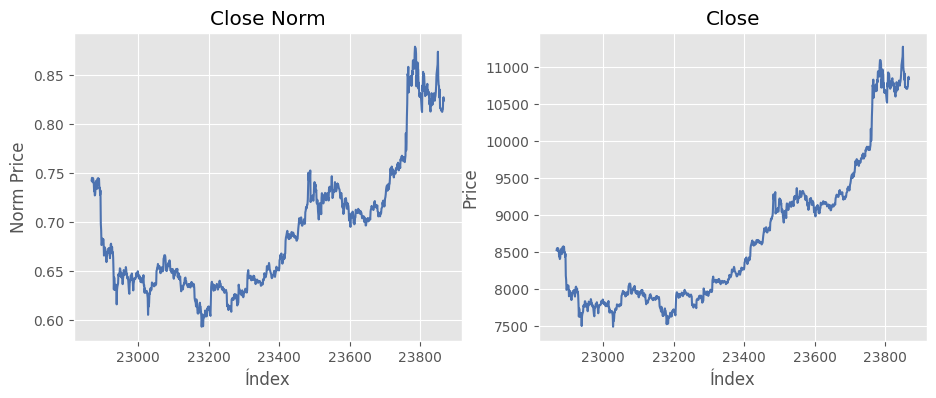

In [12]:
np.random.seed(1234567)
n = 1000  # Tamaño de la serie de ejemplo
index = int(np.random.rand() * len(data) - n)  # Índice aleatorio en la base
# Serie normalizada y estandarizada
close_norm = data['Close_Norm'][index:(index + n)]
time = data['Time'][index]  # Tiempo inicial de la serie

close = inverse(close_norm, time)  # Serie original

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
axs[0].plot(close_norm)
axs[0].set_title("Close Norm")
axs[0].set_xlabel("Índex")
axs[0].set_ylabel("Norm Price")
axs[1].plot(close)
axs[1].set_title("Close")
axs[1].set_xlabel("Índex")
axs[1].set_ylabel("Price")
plt.show()

Para el ejemplo dado, se tiene que las diferencias entre la serie original `Close` y la des-estandarización de `Close_Norm` son despreciables:

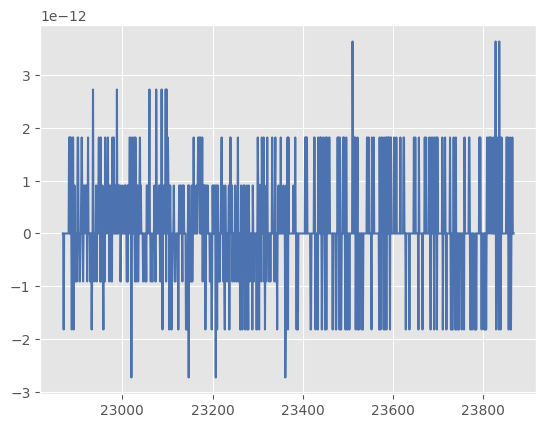

In [13]:
dif = data['Close'][index:(index + n)] - close
plt.plot(dif)
plt.show()

# Data sets finales:

In [14]:
training, validation, inverse = datasets(
    symbol='BTCUSDT',
    interval='30m',
    variables=[
        'Close_Norm', 'High_Norm', 'Low_Norm', 'Gap',
        'Close_Rate', 'Volume_Log', 'Volume_Qty'
    ],
    subsets=[80560, 20139],
    conf_level=100,
    isolated=False
)

               size   prop                 time
A             80560  80.0%  2018-02-12 00:00:00
B             20139  20.0%  2022-09-17 08:00:00
not assigned      0   0.0%                    -


In [15]:
training

,Time,Open,High,Low,Close,Volume,Close_Norm,High_Norm,Low_Norm,Gap,Close_Rate,Volume_Log,Volume_Qty
0,25306560.0,8063.82,8218.70,8053.00,8174.00,997.148934,0.444527,0.435033,0.465716,0.618860,0.576195,0.471386,0.639078
1,25306590.0,8174.00,8270.42,8139.00,8198.42,869.892112,0.445050,0.436127,0.467472,0.619254,0.542034,0.454663,0.604719
2,25306620.0,8198.42,8326.59,8154.68,8315.76,702.159269,0.447477,0.437317,0.467813,0.619254,0.578297,0.428431,0.680995
3,25306650.0,8315.76,8417.00,8270.00,8345.51,1521.901408,0.448111,0.439215,0.470162,0.619254,0.543923,0.523189,0.601109
4,25306680.0,8345.51,8425.00,8281.00,8411.09,799.721966,0.449481,0.439409,0.470410,0.619254,0.557630,0.444363,0.648382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80555,27723210.0,19853.51,19878.06,19827.41,19860.26,3287.224010,0.425296,0.415628,0.447452,0.623463,0.533660,0.617572,0.609208
80556,27723240.0,19860.26,19879.00,19842.04,19850.78,2631.002250,0.424819,0.415717,0.448272,0.619254,0.530940,0.590277,0.602523
80557,27723270.0,19851.88,19861.15,19785.49,19839.70,3597.616720,0.424245,0.414765,0.445274,0.626488,0.530681,0.628633,0.614289
80558,27723300.0,19840.72,19863.45,19819.04,19824.58,2782.183270,0.423447,0.414915,0.447092,0.625962,0.530028,0.597125,0.600964


In [16]:
validation

,Time,Open,High,Low,Close,Volume,Close_Norm,High_Norm,Low_Norm,Gap,Close_Rate,Volume_Log,Volume_Qty
80560,27723360.0,19842.22,19887.90,19841.64,19877.24,3227.92690,0.426357,0.416308,0.448349,0.620109,0.538141,0.615341,0.609074
80561,27723390.0,19876.34,19894.70,19862.00,19877.69,3149.91334,0.426409,0.416711,0.449466,0.613336,0.532541,0.612342,0.606304
80562,27723420.0,19877.69,19916.61,19866.70,19888.61,3445.50780,0.427033,0.417946,0.449747,0.619254,0.534227,0.623337,0.607855
80563,27723450.0,19888.61,19889.96,19860.57,19876.42,2752.76948,0.426399,0.416510,0.449448,0.619254,0.530506,0.595823,0.606789
80564,27723480.0,19875.59,19902.86,19850.02,19853.83,3413.70024,0.425200,0.417248,0.448911,0.613796,0.528829,0.622200,0.597392
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100694,28327380.0,37246.45,37424.22,37231.10,37339.41,996.22192,0.725549,0.720509,0.742425,0.619254,0.540460,0.471272,0.609427
100695,28327410.0,37339.41,37339.41,37210.00,37225.96,777.11175,0.722617,0.718235,0.741716,0.619254,0.522739,0.440850,0.596590
100696,28327440.0,37225.96,37239.43,37070.19,37133.22,873.40285,0.720188,0.715600,0.738214,0.619254,0.524491,0.455156,0.602146
100697,28327470.0,37133.22,37274.82,37130.18,37231.86,480.04158,0.722341,0.716248,0.739426,0.619254,0.540974,0.381881,0.610276
